# Unsupervised Learning Program Assignment 2

### Yosef Shimon Sella <br/> 

## Library Imports



In [227]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request as rqst
import zipfile
from tqdm import tqdm


## Downloading Datasets mnist_background_random & mnist_background_images
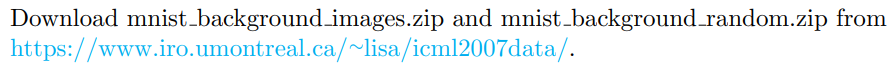

In [2]:
DATA_URL = "https://www.iro.umontreal.ca/~lisa/icml2007data/"
DATA_FILES = ["mnist_background_random.zip", "mnist_background_images.zip"]

# Function to Show Download Progress
def download_progress_hook(t):
    def update_to(block_num, block_size, total_size):
        if t.total is None:
            t.total = total_size
        t.update(block_num * block_size - t.n)
    return update_to

# Function to Download and Extract Datasets
def download_mnist_background():
    os.makedirs("data", exist_ok=True)
    for file in DATA_FILES:
        file_path = os.path.join("data", file)
        if not os.path.exists(file_path):
            with tqdm(unit='B', unit_scale=True, desc=f"Downloading {file}") as t:
                rqst.urlretrieve(DATA_URL + file, file_path, reporthook=download_progress_hook(t))
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall("data")
    print("Download complete.")

download_mnist_background()

Download complete.


## Loading mnist_background_random and subsetting 2000 images of the digits 3 and 8.
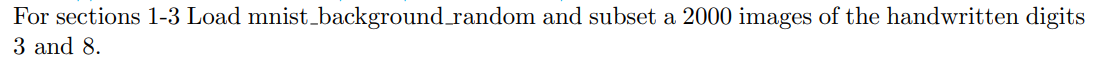

In [40]:
# Function to load and process the data
def load_and_preprocess(file_name_train, file_name_test, subset_digits = [3,8], num_samples=4000):
    
    mat_train = np.loadtxt(os.path.join("data", file_name_train))
    mat_test  = np.loadtxt(os.path.join("data", file_name_test))
    mat       = np.concatenate((mat_train, mat_test), axis=0)

    data   = mat[:, :-1]
    labels = mat[:, -1]
    mask   = np.isin(labels, subset_digits)
    
    data_subset   = data[mask][:num_samples, :]
    labels_subset = labels[mask][:num_samples]
    return data_subset, labels_subset

data, labels = load_and_preprocess("mnist_background_random_train.amat","mnist_background_random_test.amat")

## 1. K-means Clustering
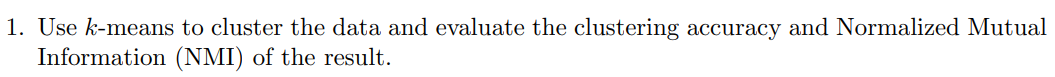

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score

from scipy.optimize import linear_sum_assignment

def map_labels(y_true, y_pred):
    unique_labels = np.unique(y_true).astype(int)
    confusion_matrix = np.zeros((2, 2), dtype=int)
    
    for i in range(len(y_true)):
        confusion_matrix[np.where(unique_labels == y_true[i])[0][0], y_pred[i]] += 1 # fills the cunfusion matrix
    
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix) # row_ind are true label assignments, col_ind are cluster assignments
    label_mapping = {col_ind[i]: unique_labels[row_ind[i]] for i in range(len(row_ind))} # Maps the true label to the corresponding cluster based on the confusion matrix
    
    return np.array([label_mapping[label] for label in y_pred])

# Function to Evaluate Clustering Results
def evaluate_clustering(y_true, y_pred):
    unique_labels = np.unique(y_true).astype(int)
    accuracy_per_digit = {}
    for label in unique_labels:
        mask = y_true == label
        accuracy_per_digit[label] = accuracy_score(y_true[mask], y_pred[mask])

        overall_accuracy = accuracy_score(y_true, y_pred)
    return {
        "NMI": round(normalized_mutual_info_score(y_true, y_pred) * 100, 2),
        "Total Accuracy": round(overall_accuracy * 100, 2),
        "Accuracy per Digit": {label: round(accuracy * 100,2) for label, accuracy in accuracy_per_digit.items()}
    }

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_res = kmeans.fit(data)
# k_labels = kmeans_res.labels_
mapped_labels = map_labels(labels, kmeans_res.labels_)
clustering_metrics = evaluate_clustering(labels, mapped_labels)
print("K-Means Clustering on Raw Data:")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")


K-Means Clustering on Raw Data:
NMI: 26.16%
Total Accuracy: 79.15%
Accuracy for digit 3: 80.96%
Accuracy for digit 8: 77.28%


## 2. Laplacian Score - compute and visualize
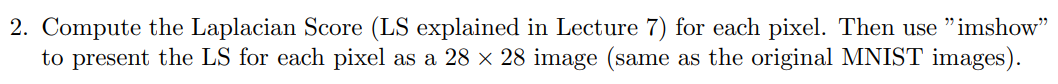

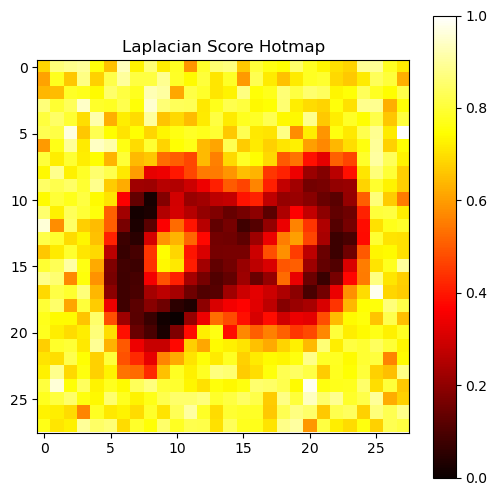

In [5]:
from scipy.spatial.distance import pdist, squareform

def compute_laplacian_score(X, sigma = 1.1):
    W = np.exp((-squareform(pdist(X, 'euclidean')) ** 2) /(2*sigma**2))
    D = np.diag(W.sum(axis=1))
    L = D - W
    LS = np.diag((X.T @ L) @ X) / np.diag(X.T @ X)
    return LS

laplacian_scores = compute_laplacian_score(data)
laplacian_score_normalized = (laplacian_scores - np.min(laplacian_scores)) / (np.max(laplacian_scores) - np.min(laplacian_scores))

plt.figure(figsize=(6,6))
plt.imshow(laplacian_score_normalized.reshape(28,28), cmap='hot', interpolation='nearest')
plt.title('Laplacian Score Hotmap')
plt.colorbar()
plt.show()



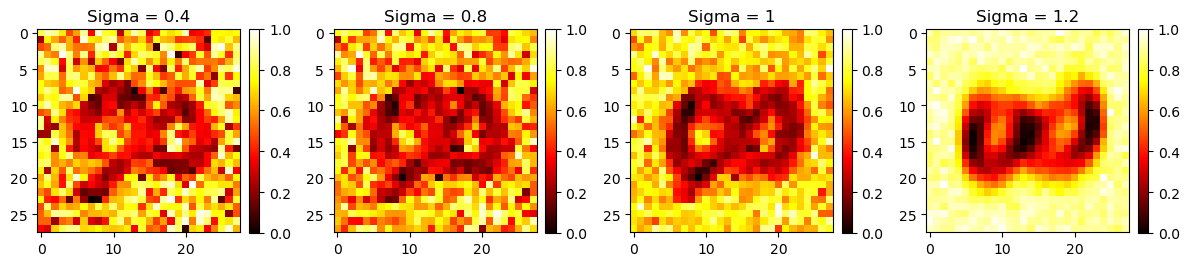

In [6]:
sigmas = [0.4, 0.8, 1, 1.2]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,6)) 

for i, sigma in enumerate(sigmas):
    laplacian_scores = compute_laplacian_score(data, sigma)
    # Normalize for better visualization
    laplacian_score_normalized = (laplacian_scores - np.min(laplacian_scores)) / (np.max(laplacian_scores) - np.min(laplacian_scores))

    ax = axes[i]

    im = ax.imshow(laplacian_score_normalized.reshape(28, 28), cmap="hot", interpolation="nearest")
    ax.set_title(f"Sigma = {sigma}")
    
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

We see that for $\sigma$ = 1 the Laplacian scores achieve a good balance, being sufficiently smooth while retaining a desirable sharpness. In contrast, for smaller values of $\sigma$ the scores are sharp but noisy, while larger values of $\sigma$ result in scores that are overly smooth.

## 3. K-Means to the Top Features of the Data
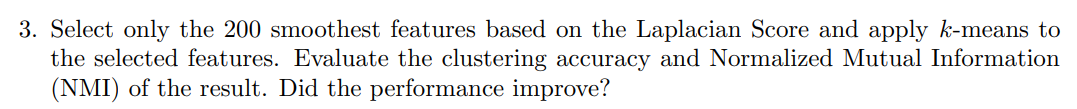

In [7]:
# Function to Select Top Features Based on Laplacian Score
def select_top_features(X, laplacian_scores, top_k=200):
    idx_sorted = np.argsort(laplacian_scores)[:top_k]
    return X[:, idx_sorted]

# Section 3: Feature Selection and K-Means Clustering
laplacian_scores = compute_laplacian_score(data, sigma=0.99)
laplacian_score_normalized = (laplacian_scores - np.min(laplacian_scores)) / (np.max(laplacian_scores) - np.min(laplacian_scores))

X_selected = select_top_features(data, laplacian_score_normalized)
kmeans_selected = KMeans(n_clusters=2, random_state=42).fit(X_selected)
mapped_labels = map_labels(labels, kmeans_selected.labels_)
clustering_metrics_selected = evaluate_clustering(labels, mapped_labels)
# print("K-Means Clustering after Feature Selection:", clustering_metrics_selected)

print("K-Means Clustering on Top 200 Features (from Laplacian Scores):")
print(f"NMI: {clustering_metrics_selected['NMI']}%")
print(f"Total Accuracy: {clustering_metrics_selected['Total Accuracy']}%")
for label, acc in clustering_metrics_selected["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")

K-Means Clustering on Top 200 Features (from Laplacian Scores):
NMI: 34.8%
Total Accuracy: 83.15%
Accuracy for digit 3: 86.47%
Accuracy for digit 8: 79.72%


Observing the results of K-means clustering on the top 200 smoothest features of the data, we find that accuracy improved for both digits, and the Normalized Mutual Information (NMI) increased as well.

This supports the effectiveness of Laplacian Scores for feature selection as they emphasize features that capture the intrinsic structure of the data and enhance the separation between clusters.

## Load mnist_background_images and subsetting 2000 images of the digits 3 and 8

In [18]:
# data_iamges, labels_images = load_and_preprocess("mnist_background_images_train.amat","mnist_background_images_test.amat")

data_iamges_3_8, labels_images_3_8 = load_and_preprocess("mnist_background_images_train.amat","mnist_background_images_test.amat", num_samples=4000)


In [19]:
def sort_by_labels(data, labels):
    sorted_labels = np.argsort(labels)
    data_sorted   = data[sorted_labels]
    labels_sorted = labels[sorted_labels]
    return data_sorted, labels_sorted

data_random_sorted, labels_random_sorted = sort_by_labels(data, labels)
data_iamges_sorted, labels_images_sorted = sort_by_labels(data_iamges_3_8, labels_images_3_8)

## 4. Apply Canonical Correlation Analysis (CCA)
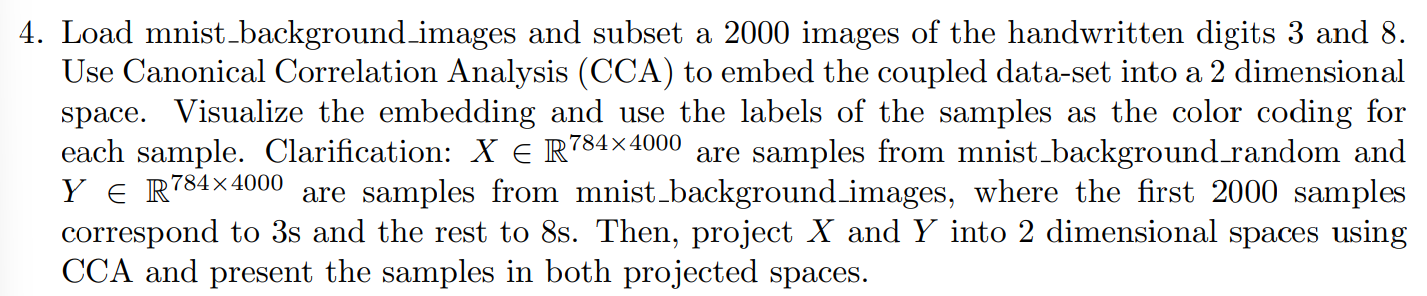

In [20]:
data_random_sorted, labels_random_sorted = data_random_sorted.T, labels_random_sorted.T
data_iamges_sorted, labels_images_sorted = data_iamges_sorted.T, labels_images_sorted.T

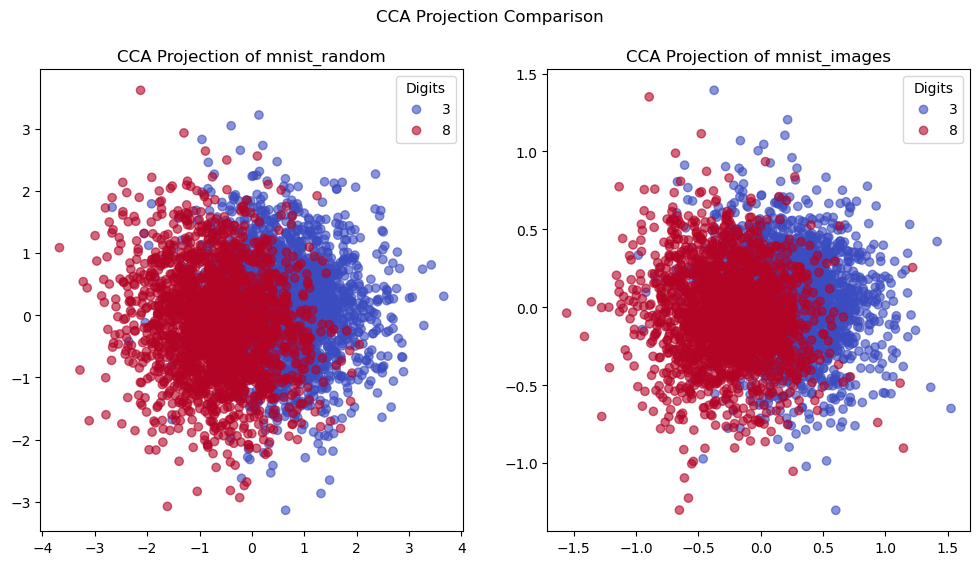

In [217]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=2)
X_cca, Y_cca = cca.fit_transform(data_random_sorted.T, data_iamges_sorted.T)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_cca[:, 0], X_cca[:, 1], c=labels_random_sorted, cmap='coolwarm', alpha=0.6)
legend_handles, legend_labels = scatter.legend_elements()
plt.legend(legend_handles, legend_labels, title="Digits")
plt.title("CCA Projection of mnist_random")

# Second subplot
plt.subplot(1, 2, 2)
scatter = plt.scatter(Y_cca[:, 0], Y_cca[:, 1], c=labels_images_sorted, cmap='coolwarm', alpha=0.6)
legend_handles, legend_labels = scatter.legend_elements()
plt.legend(legend_handles, legend_labels, title="Digits")
plt.title("CCA Projection of mnist_images")

plt.suptitle("CCA Projection Comparison")  # Title for the entire figure
plt.show()


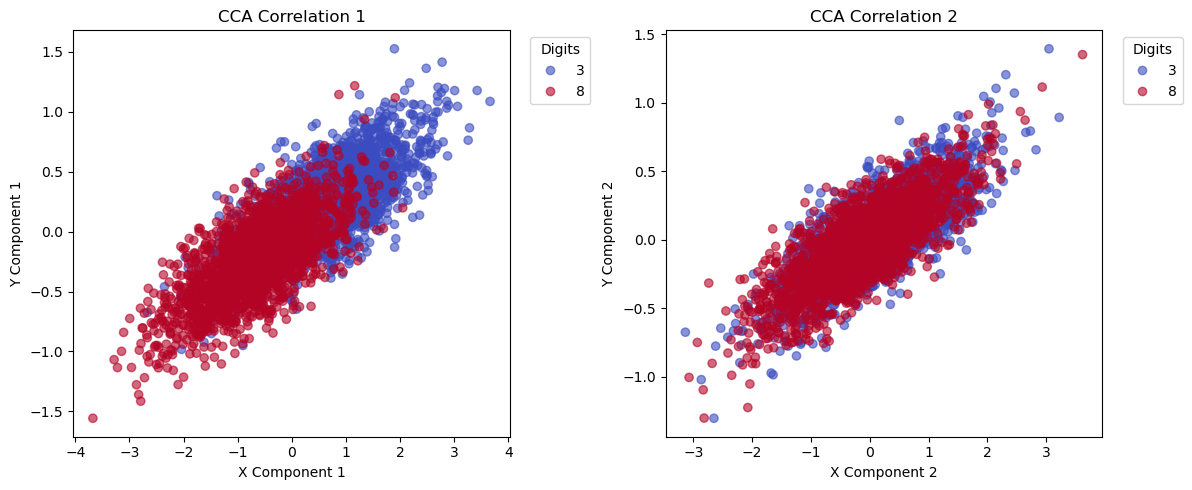

In [67]:
## just for me to visualize the correlation

num_components = X_cca.shape[1]
fig_width = max(12, 3 * num_components)  # Scale width dynamically
fig = plt.figure(figsize=(fig_width, 5))

for i in range(num_components):
    subplot = fig.add_subplot(1, num_components, i+1)
    scatter = subplot.scatter(X_cca[:, i], Y_cca[:, i], c=labels_random_sorted, cmap='coolwarm', alpha=0.6)
    
    # Create legend handles and labels
    legend_handles, legend_labels = scatter.legend_elements()
    subplot.legend(legend_handles, legend_labels, title="Digits", loc='upper right', bbox_to_anchor=(1.2, 1))

    subplot.set_xlabel(f"X Component {i+1}")
    subplot.set_ylabel(f"Y Component {i+1}")
    subplot.set_title(f"CCA Correlation {i+1}")

plt.tight_layout()
plt.show()

## 5. Compute Total Correlation
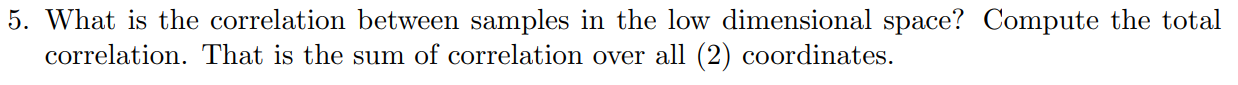

In [83]:
from scipy.stats import pearsonr

corr_X1_Y1, _ = pearsonr(X_cca[:, 0], Y_cca[:, 0])
corr_X2_Y2, _ = pearsonr(X_cca[:, 1], Y_cca[:, 1])

# Compute total correlation
total_corr = corr_X1_Y1 + corr_X2_Y2

print(f"Correlation in first dimension: {corr_X1_Y1:.4f}")
print(f"Correlation in second dimension: {corr_X2_Y2:.4f}")
print(f"Total correlation: {total_corr:.4f}")

Correlation in first dimension: 0.8088
Correlation in second dimension: 0.7910
Total correlation: 1.5998


## 6. K-Means Clustering in CCA Space
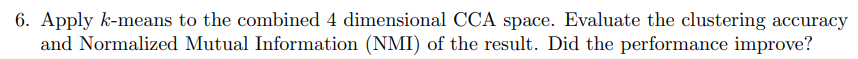

In [147]:
X_Y_cca = np.concatenate((X_cca,Y_cca), axis=1)
kmeans_cca = KMeans(n_clusters=2, random_state=42)
kmeans_cca_res = kmeans_cca.fit(X_Y_cca)

mapped_labels = map_labels(labels_random_sorted, kmeans_cca_res.labels_)
clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)

print("K-Means Clustering on CCA data (both datasets):")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")


K-Means Clustering on CCA data (both datasets):
NMI: 26.02%
Total Accuracy: 79.07%
Accuracy for digit 3: 78.41%
Accuracy for digit 8: 79.77%


Compared to the results of k-means on raw data, the performance of k-means did not improve after applying CCA.

Both the total accuracy and the Normalized Mutual Information slightly decreased. This suggests that the 2D CCA projection may have lost some discriminative information necessary for effective clustering.

Since CCA maximizes correlation rather than separability, the resulting feature space may not be optimal for k-means. Increasing the CCA embedding dimensions, may help preserve more relevant structure and improve clustering performance.

## 7. K-Means Clustering in CCA Space
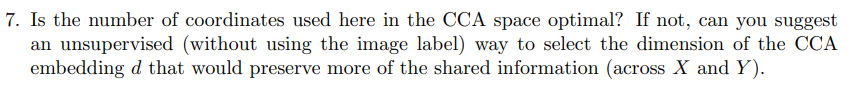

### Planned Algorithm
As we can see from the plots of each dataset after CCA, the datasets aren't easily separable. We can therefore deduce that the number of dimentions used for the CCA is suboptimal.

The method chosen to find the optimal number of CCA components is to apply CCA on all components, set a threshold for the correlation coefficients that hold most correlation in the data across dimentions, and get the number of optimal dimentions from that

Below are the results and explantions

In [ ]:
# Assuming X and Y are your two datasets (each sample should be a row)
cca_all = CCA(n_components=min(data_random_sorted.T.shape[1], data_iamges_sorted.T.shape[1]))  # Use max possible components


CCA(n_components=784)

In [105]:
cca_all_fit = cca_all.fit(data_random_sorted.T, data_iamges_sorted.T)


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [106]:
cca_all_fit_transform = cca_all.fit_transform(data_random_sorted.T, data_iamges_sorted.T)


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [150]:
X_Y_cca_all = np.concatenate((cca_all_fit_transform[0], cca_all_fit_transform[1]), axis=1)
kmeans_cca_all = KMeans(n_clusters=2, random_state=42)
kmeans_cca_all_res = kmeans_cca_all.fit(X_Y_cca_all)

mapped_labels = map_labels(labels_random_sorted, kmeans_cca_all_res.labels_)
clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)

print("K-Means Clustering on CCA data (both datasets):")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")


K-Means Clustering on CCA data (both datasets):
NMI: 0.09%
Total Accuracy: 50.22%
Accuracy for digit 3: 10.82%
Accuracy for digit 8: 90.95%


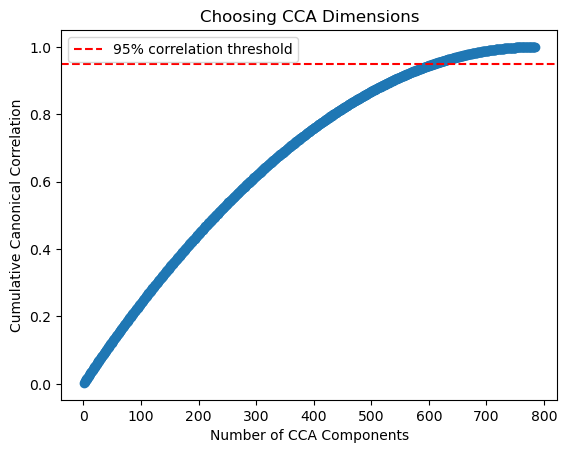

Optimal number of CCA components: 610


In [171]:
# Get canonical correlations (sorted automatically)
canonical_correlations = np.corrcoef(cca_all_fit_transform[0].T, cca_all_fit_transform[1].T)[0:data_random_sorted.T.shape[1], data_random_sorted.T.shape[1]:].diagonal()

# Compute cumulative correlation
cumulative_correlation = np.cumsum(canonical_correlations) / np.sum(canonical_correlations)

# Find the minimum number of components that retain 95% of the correlation
optimal_d = np.argmax(cumulative_correlation >= 0.95) + 1

# Plot correlation selection
plt.plot(range(1, len(cumulative_correlation) + 1), cumulative_correlation, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% correlation threshold')
plt.xlabel("Number of CCA Components")
plt.ylabel("Cumulative Canonical Correlation")
plt.title("Choosing CCA Dimensions")
plt.legend()
plt.show()

print(f"Optimal number of CCA components: {optimal_d}")


In [152]:
cca_optimal = CCA(n_components=optimal_d) 
X_cca_optimal, Y_cca_optimal = cca_optimal.fit_transform(data_random_sorted.T, data_iamges_sorted.T)


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [153]:
X_Y_cca_optimal = np.concatenate((X_cca_optimal, Y_cca_optimal), axis=1)
kmeans_cca_all = KMeans(n_clusters=2, random_state=42)
kmeans_cca_all_res = kmeans_cca_all.fit(X_Y_cca_optimal)

mapped_labels = map_labels(labels_random_sorted, kmeans_cca_all_res.labels_)
clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)

print("K-Means Clustering on CCA data (both datasets):")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")

K-Means Clustering on CCA data (both datasets):
NMI: 0.51%
Total Accuracy: 53.65%
Accuracy for digit 3: 82.44%
Accuracy for digit 8: 23.89%


We can see that the accuracy and the NMI for the 'optimal' number of dimentions (610) is very low compared to previous results. 

Though this defies the logic of our algorithm, it is understandable as higher dimentions in the data capture more noise in data. Moreover data in higher dimentions is very sparse.

Both these reasons can result in poor accurcy results when clustering the data.

### Method I've resorted to

Following the poor results achieved from the first algorithm, I have rsorted to searching manualy, with rough jumps, for a 'good enough' result for an optimal number of dimetions. 

In [205]:
cca_50 = CCA(n_components=50) 
X_cca_50, Y_cca_50 = cca_50.fit_transform(data_random_sorted.T, data_iamges_sorted.T)
X_Y_cca_50 = np.concatenate((X_cca_50, Y_cca_50), axis=1)
kmeans_cca_50 = KMeans(n_clusters=2)
kmeans_cca_50_res = kmeans_cca_50.fit(X_Y_cca_50)

mapped_labels = map_labels(labels_random_sorted, kmeans_cca_50_res.labels_)
clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)

print("K-Means Clustering on CCA data (both datasets):")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")

c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data (both datasets):
NMI: 29.69%
Total Accuracy: 80.9%
Accuracy for digit 3: 79.83%
Accuracy for digit 8: 82.0%


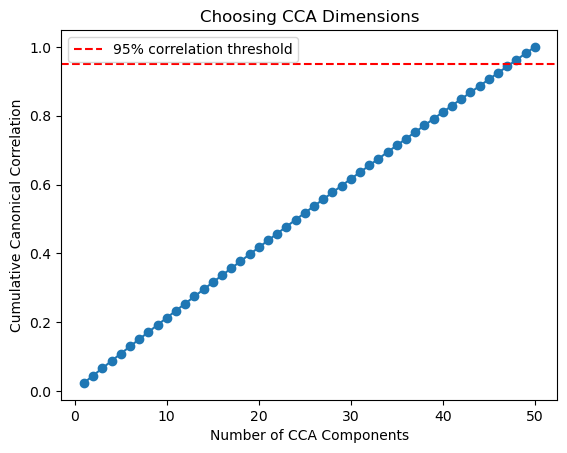

Optimal number of CCA components: 48


In [187]:
# Get canonical correlations (sorted automatically)
canonical_correlations = np.corrcoef(X_cca_50.T, Y_cca_50.T)[0:X_cca_50.shape[1], Y_cca_50.shape[1]:].diagonal()

# Compute cumulative correlation
cumulative_correlation = np.cumsum(canonical_correlations) / np.sum(canonical_correlations)

# Find the minimum number of components that retain 95% of the correlation
optimal_d = np.argmax(cumulative_correlation >= 0.95) + 1

# Plot correlation selection
plt.plot(range(1, len(cumulative_correlation) + 1), cumulative_correlation, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% correlation threshold')
plt.xlabel("Number of CCA Components")
plt.ylabel("Cumulative Canonical Correlation")
plt.title("Choosing CCA Dimensions")
plt.legend()
plt.show()

print(f"Optimal number of CCA components: {optimal_d}")

In [226]:
cca_50 = CCA(n_components=50) 
X_cca_50, Y_cca_50 = cca_50.fit_transform(data_random_sorted.T, data_iamges_sorted.T)
X_Y_cca_50 = np.concatenate((X_cca_50, Y_cca_50), axis=1)
kmeans_cca_50 = KMeans(n_clusters=2, random_state=42)
kmeans_cca_50_res = kmeans_cca_50.fit(X_Y_cca_50)

mapped_labels = map_labels(labels_random_sorted, kmeans_cca_50_res.labels_)
clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)

print("K-Means Clustering on CCA data - 50 Dimentions (both datasets):")
print(f"NMI: {clustering_metrics['NMI']}%")
print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
for label, acc in clustering_metrics["Accuracy per Digit"].items():
    print(f"Accuracy for digit {label}: {acc}%")


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 50 Dimentions (both datasets):
NMI: 29.76%
Total Accuracy: 80.95%
Accuracy for digit 3: 80.62%
Accuracy for digit 8: 81.29%


In [222]:
def run_cca_kmeans(n_components):
    # Step 1: Apply CCA with the given number of components
    cca = CCA(n_components=n_components)
    X_cca, Y_cca = cca.fit_transform(data_random_sorted.T, data_iamges_sorted.T)
    
    # Step 2: Concatenate the transformed datasets
    X_Y_cca = np.concatenate((X_cca, Y_cca), axis=1)
    
    # Step 3: Run K-Means on the transformed data
    kmeans_cca = KMeans(n_clusters=2, random_state=42)
    kmeans_cca_res = kmeans_cca.fit(X_Y_cca)
    
    # Step 4: Map predicted labels to actual labels
    mapped_labels = map_labels(labels_random_sorted, kmeans_cca_res.labels_)
    
    # Step 5: Evaluate clustering performance
    clustering_metrics = evaluate_clustering(labels_random_sorted, mapped_labels)
    
    # Step 6: Print results
    print(f"K-Means Clustering on CCA data - {n_components} Dimensions (both datasets):")
    print(f"NMI: {clustering_metrics['NMI']}%")
    print(f"Total Accuracy: {clustering_metrics['Total Accuracy']}%")
    for label, acc in clustering_metrics["Accuracy per Digit"].items():
        print(f"Accuracy for digit {label}: {acc}%")



In [225]:
num_components_list = [100, 150, 200, 250, 300]

for _, num_components in enumerate(num_components_list):
    run_cca_kmeans(n_components=num_components)

c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 100 Dimensions (both datasets):
NMI: 29.55%
Total Accuracy: 80.85%
Accuracy for digit 3: 80.37%
Accuracy for digit 8: 81.34%


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 150 Dimensions (both datasets):
NMI: 29.98%
Total Accuracy: 81.03%
Accuracy for digit 3: 83.52%
Accuracy for digit 8: 78.44%


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 200 Dimensions (both datasets):
NMI: 31.29%
Total Accuracy: 81.67%
Accuracy for digit 3: 81.36%
Accuracy for digit 8: 82.0%


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 250 Dimensions (both datasets):
NMI: 29.43%
Total Accuracy: 80.8%
Accuracy for digit 3: 81.01%
Accuracy for digit 8: 80.58%


c:\Users\yossi\anaconda3\envs\venv_UL_prog2\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


K-Means Clustering on CCA data - 300 Dimensions (both datasets):
NMI: 26.65%
Total Accuracy: 79.38%
Accuracy for digit 3: 77.87%
Accuracy for digit 8: 80.94%


After checking for different values for the number of dimentions we get that the best results was obtained for 200 dimentions, though better results may be around 200 - in the range [150, 250].

Albeit, for the values checked, 200 components gave the best overall results, both in terms of NMI and overall acurracy.

### Notes

Pardon the messy structure of the final part (part 7). Since the runtimes for each cell were substantial, it would have taken much more time to restructure the cells and the code.  